In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import feature_column
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc, RocCurveDisplay, roc_auc_score, classification_report, confusion_matrix, roc_curve
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

2023-10-25 22:57:56.839062: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-25 22:57:56.869901: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-25 22:57:56.869935: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-25 22:57:56.869967: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-25 22:57:56.876695: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-25 22:57:56.877578: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [69]:
df = pd.read_csv('datasets/numerical_data.csv')

In [27]:
num_var = ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
cat_var = ['Smoking', 'AgeCategory', 'Race', 'Diabetic', 'GenHealth', 'Asthma']
bin_var = ['AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'KidneyDisease', 'SkinCancer', 'PhysicalActivity']

In [15]:
for column in df.columns:
    df[column] = df[column].astype(int)

In [31]:
target = df.pop('HeartDisease')
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.2, random_state=42)

In [32]:
# Normalize numerical features
scaler = StandardScaler()
X_train[num_var] = scaler.fit_transform(X_train[num_var])
X_test[num_var] = scaler.transform(X_test[num_var])

In [57]:
# Define feature columns
feature_columns = []

# Numeric feature columns
for feature_name in num_var:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

# Categorical feature columns (use one-hot encoding)
for feature_name in cat_var:
    vocabulary_list = df[feature_name].unique()
    cat_column = tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary_list)
    one_hot_column = tf.feature_column.indicator_column(cat_column)
    feature_columns.append(one_hot_column)

# Binary feature columns (use one-hot encoding)
for feature_name in bin_var:
    vocabulary_list = df[feature_name].unique()
    bin_column = tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary_list)
    one_hot_column = tf.feature_column.indicator_column(bin_column)
    feature_columns.append(one_hot_column)

In [41]:
# Define a custom initializer with a constant value
initializer = tf.keras.initializers.Constant(0.5) 

In [66]:
# Build and compile the model with the custom initializer for a specific layer
model = tf.keras.Sequential([
        tf.keras.layers.DenseFeatures(feature_columns),
        tf.keras.layers.Dense(units=128, activation='relu', kernel_initializer=initializer),  # Apply the initializer
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Dense(units=128, activation='relu'),
        tf.keras.layers.Dense(units=1, activation='sigmoid')
    ])

# Add the AUC metric to the list of metrics
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])

In [11]:
# Convert data to TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((dict(X_train), y_train)).batch(32)
eval_ds = tf.data.Dataset.from_tensor_slices((dict(X_test), y_test)).batch(32)

**Early stopping** is a technique used to prevent overfitting and can be particularly beneficial when training deep learning models.

<img src='Images/tf4.jpg'>

Early stopping is employed to monitor the validation loss during training. If the validation loss starts to increase or doesn't improve for a certain number of consecutive epochs (defined by the patience parameter), the training is stopped to prevent overfitting.

- Preventing Overfitting: Overfitting occurs when the model learns to perform exceptionally well on the training data but does not generalize well to unseen data. Stopping training early when validation loss increases or plateaus helps prevent overfitting.

- Optimal Model: The model saved when early stopping is triggered is often the one that generalizes best to unseen data. In your case, the model at epoch 27 is likely the one that performs well on both the training and validation data.

- Saves Time: Early stopping can also save training time, especially when training deep and complex models. Instead of training for a fixed number of epochs, you train until you see no further improvement, which can be more efficient.

In [12]:
# Implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,  # Number of epochs with no improvement after which training will be stopped.
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity.
)

In [13]:
# Train the model
history = model.fit(train_ds, validation_data=eval_ds, epochs=100, callbacks=[early_stopping])

Epoch 1/100
9496/9496 [==============================] - 19s 2ms/step - loss: 0.2009 - accuracy: 0.9378 - auc: 0.7824 - val_loss: 0.1846 - val_accuracy: 0.9385 - val_auc: 0.8388
Epoch 2/100
9496/9496 [==============================] - 18s 2ms/step - loss: 0.1844 - accuracy: 0.9391 - auc: 0.8311 - val_loss: 0.1842 - val_accuracy: 0.9382 - val_auc: 0.8406
Epoch 3/100
9496/9496 [==============================] - 18s 2ms/step - loss: 0.1830 - accuracy: 0.9392 - auc: 0.8351 - val_loss: 0.1827 - val_accuracy: 0.9383 - val_auc: 0.8413
Epoch 4/100
9496/9496 [==============================] - 18s 2ms/step - loss: 0.1825 - accuracy: 0.9392 - auc: 0.8365 - val_loss: 0.1822 - val_accuracy: 0.9386 - val_auc: 0.8423
Epoch 5/100
9496/9496 [==============================] - 18s 2ms/step - loss: 0.1817 - accuracy: 0.9392 - auc: 0.8388 - val_loss: 0.1821 - val_accuracy: 0.9385 - val_auc: 0.8430
Epoch 6/100
9496/9496 [==============================] - 18s 2ms/step - loss: 0.1811 - accuracy: 0.9393 - auc:

In [14]:
# Evaluate the model
predictions = model.predict(eval_ds)
bin_predictions = [1 if p > 0.5 else 0 for p in predictions]

2374/2374 [==============================] - 3s 1ms/step


In [15]:
# Generate classification report
print(classification_report(y_test, bin_predictions))

# Calculate AUC score
print("AUC Score: ", '{0:.2%}'.format(roc_auc_score(y_test, predictions)))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     71267
           1       0.70      0.09      0.15      4694

    accuracy                           0.94     75961
   macro avg       0.82      0.54      0.56     75961
weighted avg       0.93      0.94      0.92     75961

AUC Score:  86.05%


In [16]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_features (DenseFeatu  multiple                  0         
 res)                                                            
                                                                 
 dense (Dense)               multiple                  7040      
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 dense_1 (Dense)             multiple                  16512     
                                                                 
 dense_2 (Dense)             multiple                  129       
                                                                 
Total params: 23681 (92.50 KB)
Trainable params: 23681 (92.50 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

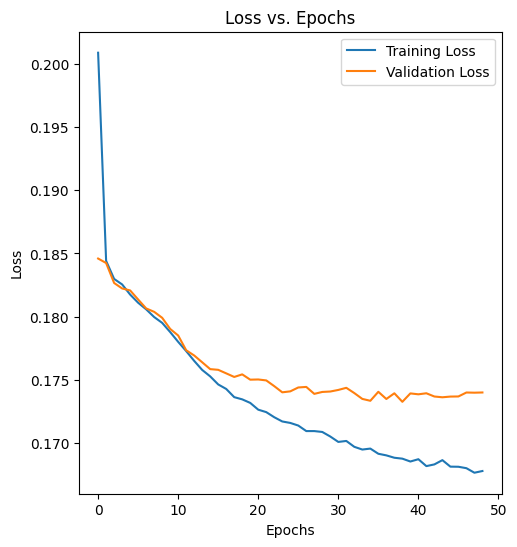

In [17]:
# Plot training history
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

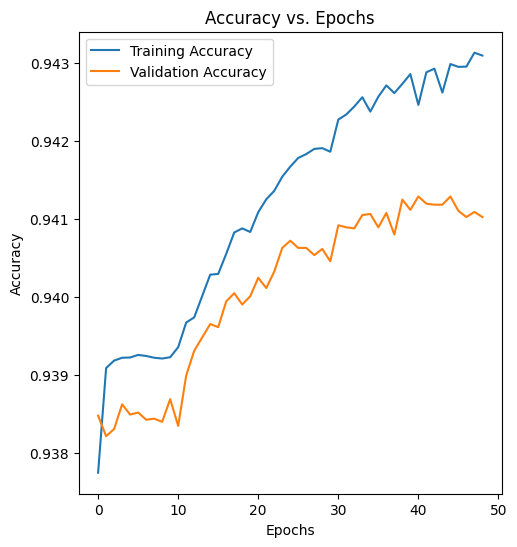

In [18]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

In [22]:
# Generate predictions and calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

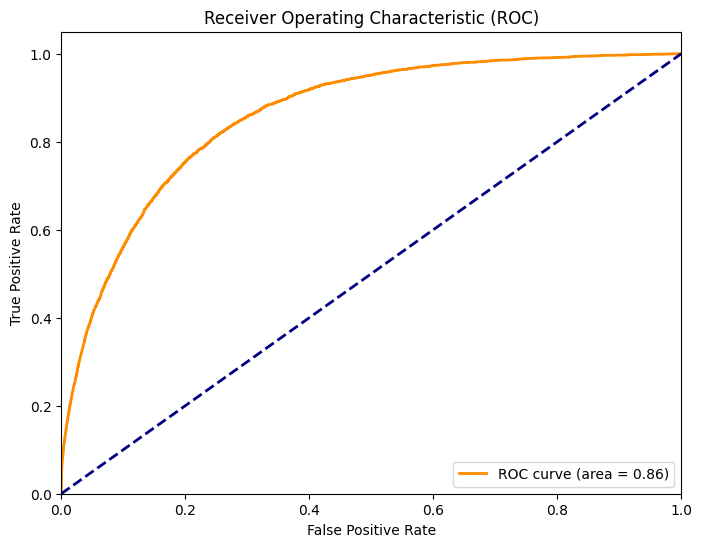

In [23]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

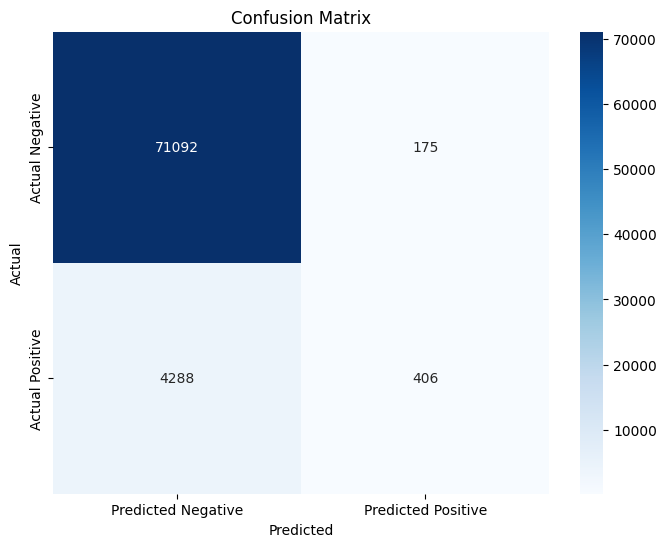

In [25]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, bin_predictions)

# Display the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

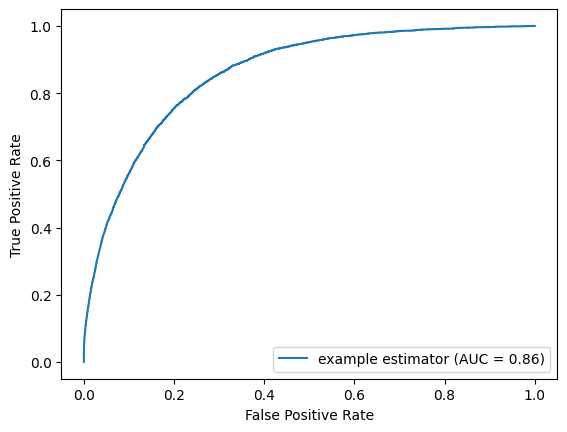

In [36]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='example estimator')
display.plot()

Kaggle dataset

In [40]:
kaggle_df = pd.read_csv('datasets/heart_2020_cleaned.csv')

In [41]:
num_var = ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
cat_var = ['Smoking', 'AgeCategory', 'Race', 'Diabetic', 'GenHealth', 'Asthma']
bin_var = ['AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'KidneyDisease', 'SkinCancer', 'PhysicalActivity']

In [42]:
# Label Encoding for ordinal variables
label_encoder = LabelEncoder()
for col in cat_var:
    kaggle_df[col] = label_encoder.fit_transform(kaggle_df[col])

for col in num_var:
    kaggle_df[col] = label_encoder.fit_transform(kaggle_df[col])

for col in bin_var:
    kaggle_df[col] = label_encoder.fit_transform(kaggle_df[col])

# Define a dictionary to map values
mapping = {'No': 0, 'Yes': 1}

# Apply the mapping to the column
kaggle_df['HeartDisease'] = kaggle_df['HeartDisease'].replace(mapping)

In [43]:
kaggle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   HeartDisease      319795 non-null  int64
 1   BMI               319795 non-null  int64
 2   Smoking           319795 non-null  int64
 3   AlcoholDrinking   319795 non-null  int64
 4   Stroke            319795 non-null  int64
 5   PhysicalHealth    319795 non-null  int64
 6   MentalHealth      319795 non-null  int64
 7   DiffWalking       319795 non-null  int64
 8   Sex               319795 non-null  int64
 9   AgeCategory       319795 non-null  int64
 10  Race              319795 non-null  int64
 11  Diabetic          319795 non-null  int64
 12  PhysicalActivity  319795 non-null  int64
 13  GenHealth         319795 non-null  int64
 14  SleepTime         319795 non-null  int64
 15  Asthma            319795 non-null  int64
 16  KidneyDisease     319795 non-null  int64
 17  SkinCancer

In [44]:
target = kaggle_df.pop('HeartDisease')
X_train, X_test, y_train, y_test = train_test_split(kaggle_df, target, test_size=0.2, random_state=42)

In [45]:
# Normalize numerical features
scaler = StandardScaler()
X_train[num_var] = scaler.fit_transform(X_train[num_var])
X_test[num_var] = scaler.transform(X_test[num_var])

In [46]:
# Define feature columns
feature_columns = []

# Numeric feature columns
for feature_name in num_var:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

# Categorical feature columns (use one-hot encoding)
for feature_name in cat_var:
    vocabulary_list = kaggle_df[feature_name].unique()
    cat_column = tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary_list)
    one_hot_column = tf.feature_column.indicator_column(cat_column)
    feature_columns.append(one_hot_column)

# Binary feature columns (use one-hot encoding)
for feature_name in bin_var:
    vocabulary_list = kaggle_df[feature_name].unique()
    bin_column = tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary_list)
    one_hot_column = tf.feature_column.indicator_column(bin_column)
    feature_columns.append(one_hot_column)

In [47]:
# Define a custom initializer with a constant value
initializer = tf.keras.initializers.Constant(0.5) 

In [48]:
# Build and compile the model with the custom initializer for a specific layer
model = tf.keras.Sequential([
        tf.keras.layers.DenseFeatures(feature_columns),
        tf.keras.layers.Dense(units=128, activation='relu', kernel_initializer=initializer),  # Apply the initializer
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Dense(units=128, activation='relu'),
        tf.keras.layers.Dense(units=1, activation='sigmoid')
    ])

# Add the AUC metric to the list of metrics
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])

In [49]:
# Convert data to TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((dict(X_train), y_train)).batch(32)
eval_ds = tf.data.Dataset.from_tensor_slices((dict(X_test), y_test)).batch(32)

In [50]:
# Implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,  # Number of epochs with no improvement after which training will be stopped.
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity.
)

In [51]:
# Train the model
history = model.fit(train_ds, validation_data=eval_ds, epochs=100, callbacks=[early_stopping])

Epoch 1/100


7995/7995 [==============================] - 17s 2ms/step - loss: 0.2548 - accuracy: 0.9127 - auc_2: 0.7790 - val_loss: 0.2344 - val_accuracy: 0.9133 - val_auc_2: 0.8368
Epoch 2/100
7995/7995 [==============================] - 16s 2ms/step - loss: 0.2287 - accuracy: 0.9160 - auc_2: 0.8339 - val_loss: 0.2315 - val_accuracy: 0.9141 - val_auc_2: 0.8374
Epoch 3/100
7995/7995 [==============================] - 16s 2ms/step - loss: 0.2270 - accuracy: 0.9164 - auc_2: 0.8374 - val_loss: 0.2312 - val_accuracy: 0.9138 - val_auc_2: 0.8376
Epoch 4/100
7995/7995 [==============================] - 15s 2ms/step - loss: 0.2265 - accuracy: 0.9165 - auc_2: 0.8386 - val_loss: 0.2308 - val_accuracy: 0.9141 - val_auc_2: 0.8382
Epoch 5/100
7995/7995 [==============================] - 15s 2ms/step - loss: 0.2261 - accuracy: 0.9165 - auc_2: 0.8393 - val_loss: 0.2310 - val_accuracy: 0.9140 - val_auc_2: 0.8385
Epoch 6/100
7995/7995 [==============================] - 15s 2ms/step - loss: 0.2256 - accuracy: 0.916

In [52]:
# Evaluate the model
predictions = model.predict(eval_ds)
bin_predictions = [1 if p > 0.5 else 0 for p in predictions]

1999/1999 [==============================] - 3s 1ms/step


In [53]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_features_2 (DenseFea  multiple                  0         
 tures)                                                          
                                                                 
 dense_6 (Dense)             multiple                  6528      
                                                                 
 dropout_2 (Dropout)         multiple                  0         
                                                                 
 dense_7 (Dense)             multiple                  16512     
                                                                 
 dense_8 (Dense)             multiple                  129       
                                                                 
Total params: 23169 (90.50 KB)
Trainable params: 23169 (90.50 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [54]:
# Generate classification report
print(classification_report(y_test, bin_predictions))

# Calculate AUC score
print("AUC Score: ", '{0:.2%}'.format(roc_auc_score(y_test, predictions)))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     58367
           1       0.54      0.10      0.17      5592

    accuracy                           0.91     63959
   macro avg       0.73      0.55      0.56     63959
weighted avg       0.89      0.91      0.89     63959

AUC Score:  84.06%


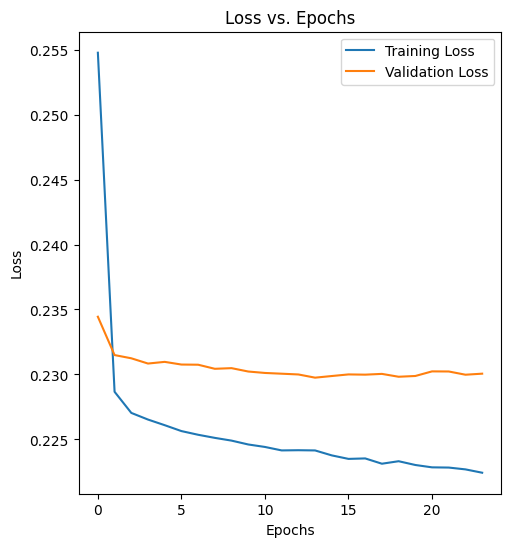

In [55]:
# Plot training history
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

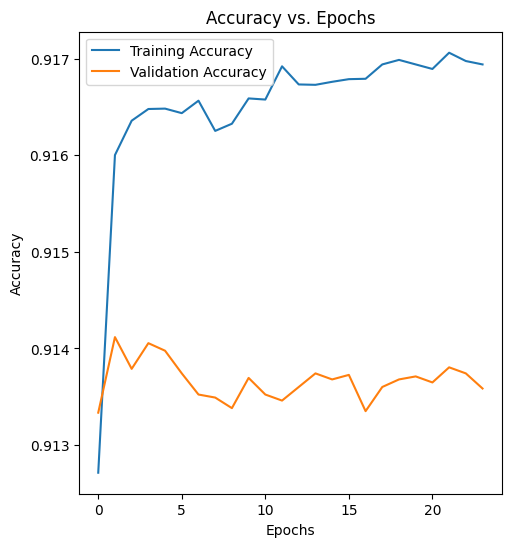

In [56]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

In [57]:
# Generate predictions and calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

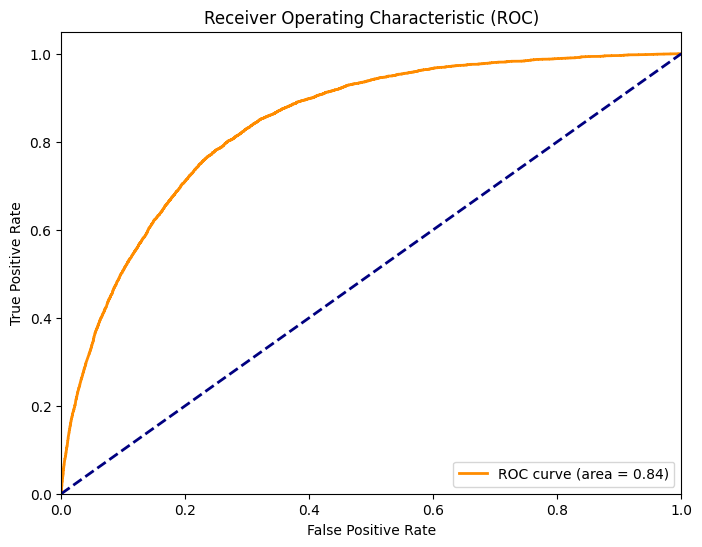

In [58]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

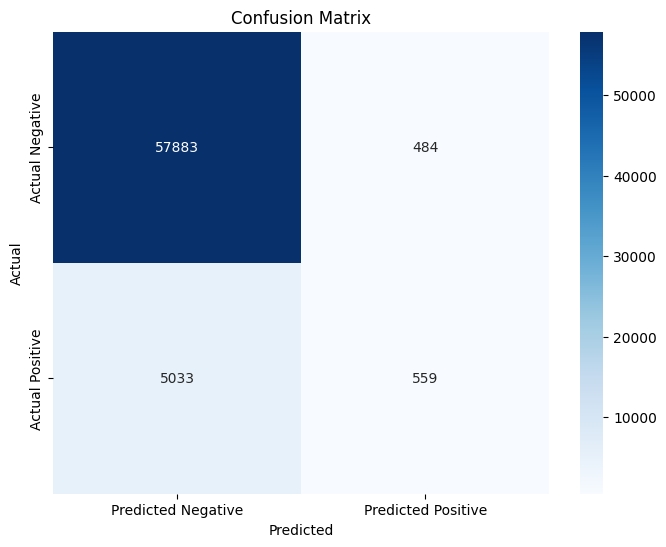

In [59]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, bin_predictions)

# Display the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()